In [27]:
import os
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm

In [28]:
split = 'train'
use_bg = True
bg_dir = '/home/chuongh/vm2m/data/bg'
image_dir = f'/home/chuongh/vm2m/data/VideoMatte240K/{split}/fgr'
pha_dir = f'/home/chuongh/vm2m/data/VideoMatte240K/{split}/clean_pha'
out_dir = f'/home/chuongh/vm2m/data/VideoMatte240K_syn/{split}'

In [20]:
# Find valid videos with one instance
valid_videos = []
with open("/home/chuongh/vm2m/vm2m/dataloader/valid_vm240k_train.txt", "r") as f:
    for line in f:
        valid_videos.append(line.strip())

# # Check mask of the valid_videos, if there are >1 connected components, remove it 
# new_valid_videos = []
# for valid_video in tqdm(valid_videos):
#     pha_path = os.path.join(pha_dir, valid_video)
#     pha_list = os.listdir(pha_path)
#     is_valid = True
#     for pha_name in pha_list[1::5][:10]:
#         pha = (np.array(Image.open(os.path.join(pha_path, pha_name))) > 127).astype(np.uint8)
#         labels, num = sklabel(pha, return_num=True)
#         if num == 1:
#             continue
#         areas = []
#         for i in range(1, num+1):
#             areas.append(np.sum(labels==i))
#         areas = sorted(areas, reverse=True)
#         if len(areas) > 1 and (areas[1] * 1.0 / areas[0]) > 0.2:
#             is_valid = False
#             break
#     if is_valid:
#         new_valid_videos.append(valid_video)
#     else:
#         print("Invalid video: ", valid_video)

In [30]:
with open("/home/chuongh/vm2m/vm2m/dataloader/valid_vm240k_train.txt", "w") as f:
    for valid_video in new_valid_videos:
        f.write(valid_video + "\n")

In [32]:
valid_videos = new_valid_videos
len(valid_videos)

414

In [86]:
no_videos = np.random.randint(2, 5)
video_names = np.random.choice(valid_videos, no_videos, replace=False)
# def combine_video(video_names):
# Get random background
while True:
    bg_name = np.random.choice(os.listdir(bg_dir))
    bg_path = os.path.join(bg_dir, bg_name)
    bg = cv2.imread(bg_path)[:, :, ::-1]
    if bg.shape[1] > bg.shape[0]:
        break


# Get no.frames of each video --> min no.frames
no_frames = []
for video_name in video_names:
    fgr_path = os.path.join(image_dir, video_name)
    no_frames.append(len(os.listdir(fgr_path)))

new_no_frames = min(no_frames)

# Compute the (x, y, w, h) of fg in each video, random select start frame
fg_bboxes = []
start_frames = []
print(len(video_names))
for video_name in video_names:
    alpha_paths = os.listdir(os.path.join(pha_dir, video_name))
    alpha_paths = sorted(alpha_paths)
    if len(alpha_paths) == new_no_frames:
        start_frame = 0
    else:
        start_frame = np.random.randint(0, len(alpha_paths)-new_no_frames)
    start_frames.append(start_frame)
    x1, y1, x2, y2 = 999999, 999999, 0, 0
    for alpha_name in tqdm(alpha_paths[start_frame:start_frame+new_no_frames]):
        # Read alpha
        alpha = Image.open(os.path.join(pha_dir, video_name, alpha_name)).convert('L')

        # Threshold alpha > 1.0/255.0
        alpha = np.array(alpha).astype(np.uint8)
        box = cv2.boundingRect(alpha)
        box = list(box)
        box[2] += box[0]
        box[3] += box[1]
        x1 = min(x1, box[0])
        y1 = min(y1, box[1])
        x2 = max(x2, box[2])
        y2 = max(y2, box[3])
        
    fg_bboxes.append((x1, y1, x2 - x1, y2 - y1))
# Compute the resize ratio with regarding to the background size: height = 70-90% of bg height
h, w = bg.shape[:2]
resized_ratios = []
space_w = w // 2
for box in fg_bboxes:
    ratio = 1.0
    if box[3] > 0.7 * h:
        ratio = np.random.uniform(0.7, 0.9) * h / box[3]
    if box[2] > space_w:
        ratio = min(ratio, np.random.uniform(0.8, 1.0) * space_w / box[2])
    resized_ratios.append(ratio)

# Compute x, y for each video
x = 0
composited_bboxes = []
for i in range(len(video_names)):
    box = fg_bboxes[i]
    ratio = resized_ratios[i]
    new_h = int(box[3] * ratio)
    new_w = int(box[2] * ratio)
    x1 = x + np.random.randint(0, new_w // 2) * np.random.choice([-1, 1])
    x1 = min(x1, w - new_w)
    y1 = np.random.randint(0, h - new_h)
    composited_bboxes.append((x1, y1, new_w, new_h))
    x = x1 + new_w // 2


# Combine the video: fgr and alpha

# x = 0
for i in range(new_no_frames):
    new_image = Image.fromarray(bg)
    all_alphas = []
    for vid_idx in range(len(video_names)):
        video_name = video_names[vid_idx]
        start_frame = start_frames[vid_idx]
        alpha_names = os.listdir(os.path.join(pha_dir, video_name))
        alpha_names = sorted(alpha_names)
        alpha_name = alpha_names[start_frame: start_frame + new_no_frames][i]
        alpha = Image.open(os.path.join(pha_dir, video_name, alpha_name)).convert('L')

        fgr_names = os.listdir(os.path.join(image_dir, video_name))
        fgr_names = sorted(fgr_names)
        fgr_name = fgr_names[start_frame: start_frame + new_no_frames][i]
        fgr = Image.open(os.path.join(image_dir, video_name, fgr_name)).convert('RGB')

        # Crop and resize fg and alpha
        box = fg_bboxes[vid_idx]
        ratio = resized_ratios[vid_idx]
        new_h = int(box[3] * ratio)
        new_w = int(box[2] * ratio)
        alpha = alpha.crop((box[0], box[1], box[0] + box[2], box[1] + box[3]))
        fgr = fgr.crop((box[0], box[1], box[0] + box[2], box[1] + box[3]))
        alpha = alpha.resize((new_w, new_h), Image.BILINEAR)
        fgr = fgr.resize((new_w, new_h), Image.BILINEAR)

        # Blend fg and new_image
        x1, y1, new_w, new_h = composited_bboxes[vid_idx]
        new_image.paste(fgr, (x1, y1), alpha)

        new_alpha = Image.new('L', (w, h), 0)
        new_alpha.paste(alpha, (x1, y1))

        all_alphas.append(np.array(new_alpha)/ 255.0)
        for j in range(len(all_alphas) - 1):
            all_alphas[j] = all_alphas[j] * (1 - all_alphas[-1])
    break

# for video_name, start_frame in zip(video_names, start_frames):
#     alpha_names = os.listdir(os.path.join(pha_dir, video_name))
#     alpha_names = sorted(alpha_names)
#     fg_names = os.listdir(os.path.join(image_dir, video_name))
#     fg_names = sorted(fg_names)
#     for fg_path, pha_path in zip(fg_names[start_frame: start_frame + new_no_frames], alpha_names[start_frame: start_frame + new_no_frames]):
#         new_

4


100%|██████████| 319/319 [00:03<00:00, 98.30it/s] 


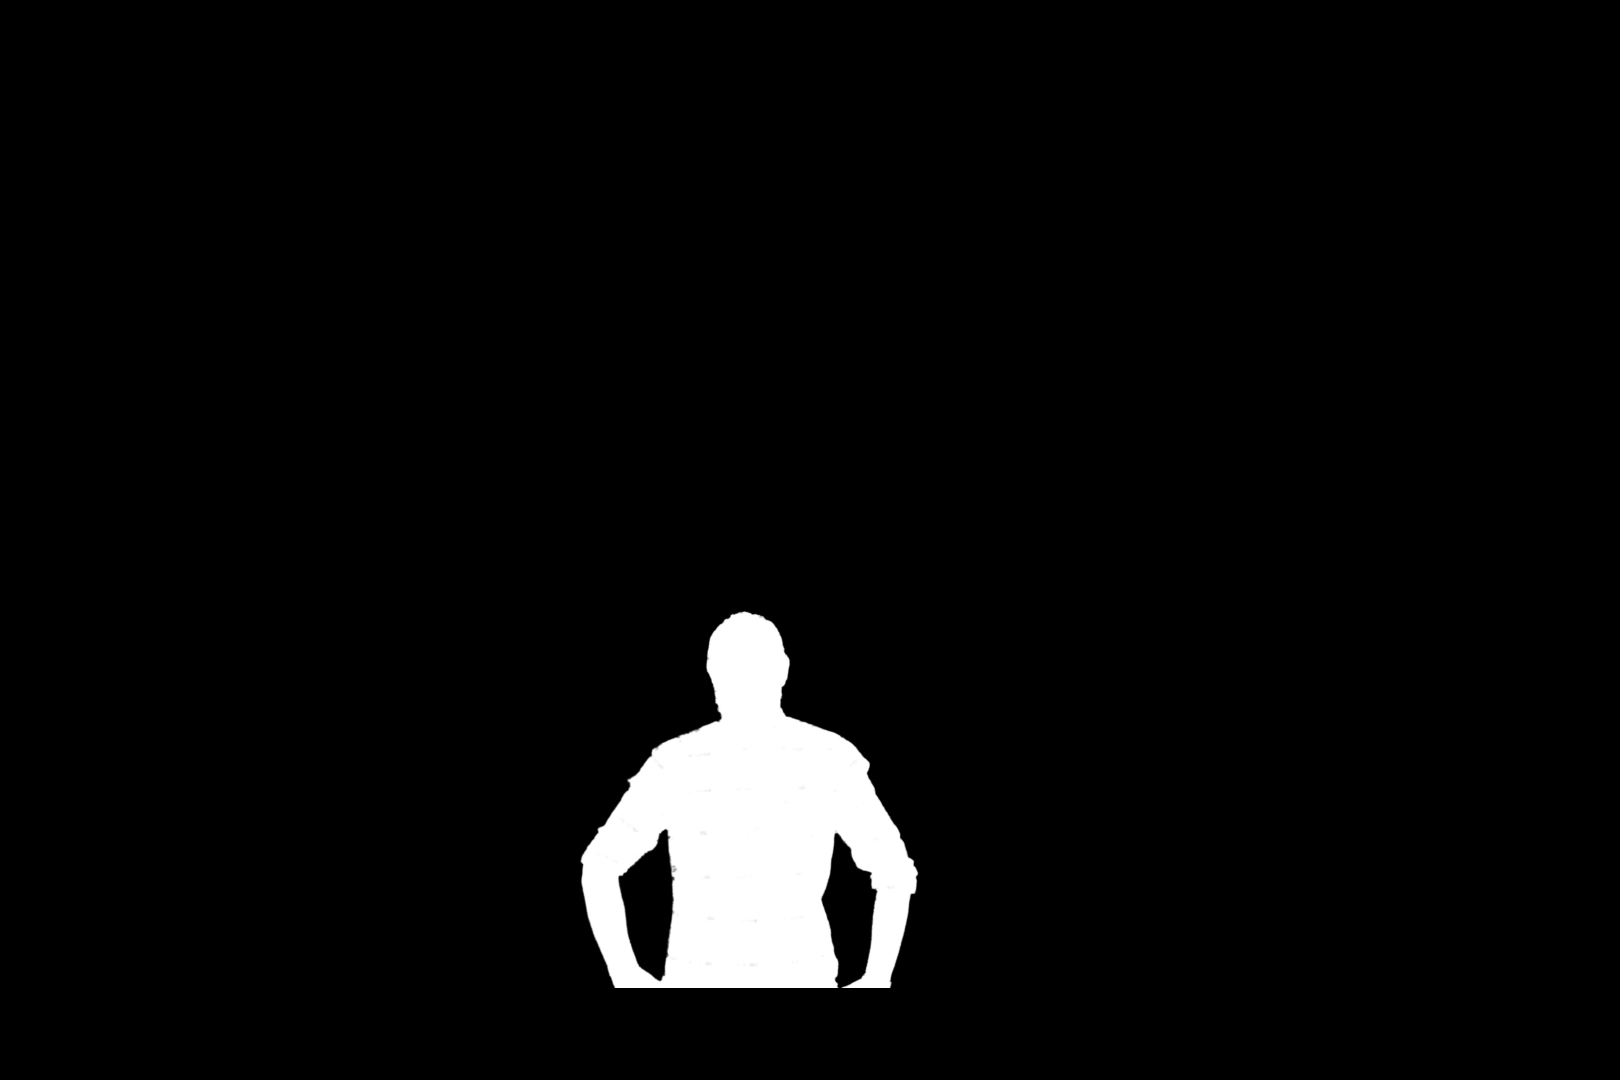

In [66]:
Image.fromarray((all_alphas[2] * 255).astype(np.uint8))

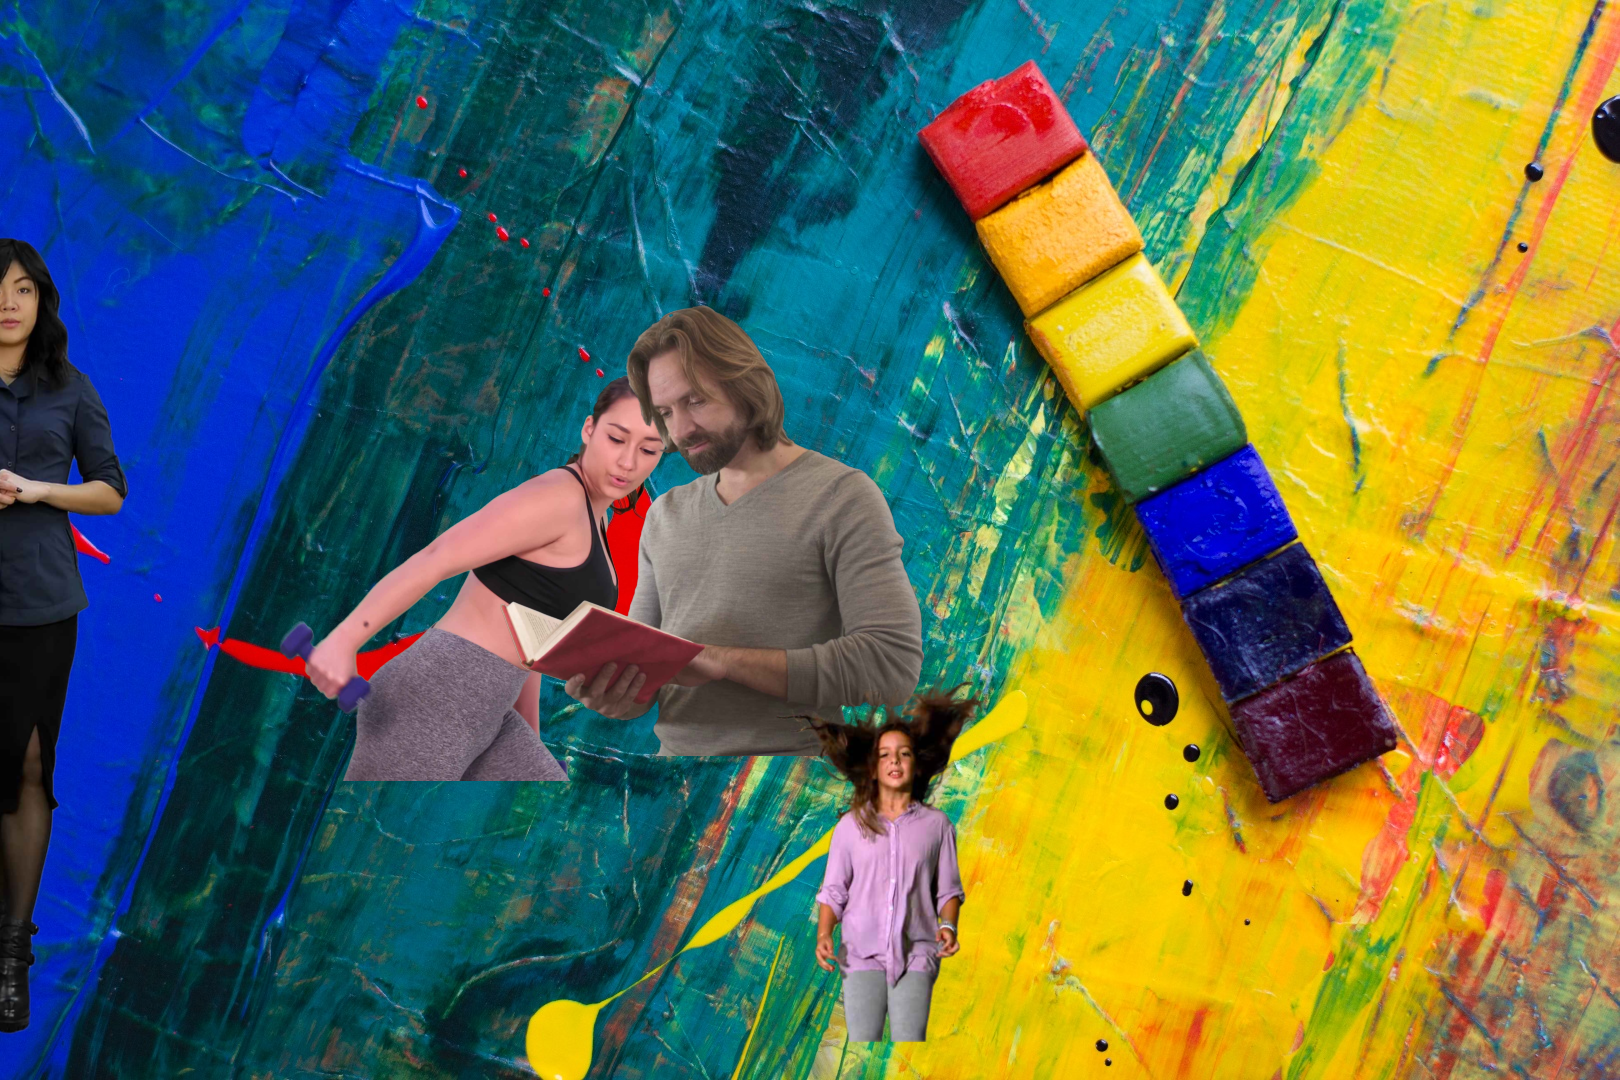

In [87]:
new_image

In [88]:
resized_ratios

[0.415713252529725,
 0.22178910343314967,
 0.2302370787666777,
 0.5091389622674413]